## Importation des librairies

Initialisation de la date et du chemin d'export

In [1]:
from pathlib import Path
from pyomeca import Analogs
from scipy import signal, fftpack, fft, integrate
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xarray as xr
import feather
import csv
import re
import seaborn.objects as so
import matplotlib as mpl
import os
from scipy.signal import butter, filtfilt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from itertools import chain
import configparser
import tkinter as tk
from tkinter import filedialog

from datetime import date

today = date.today().strftime("%Y%m%d")

path_export = "C:/Users/l.boisson/Documents/1- Projets traitement/ActivGun/Exports/"

sns.set_theme()
sns.set_style("white")

## Détermination du chemin d'import des fichiers

In [2]:
# Create a GUI window
root = tk.Tk()
root.withdraw()  # Hide the main window

# Ask user to select the data folder using a file explorer dialog
# Check if data_folder_path is already loaded in Jupyter variables
try:
    data_folder_path
except NameError:
    data_folder_path = None

if data_folder_path is None:
    root = tk.Tk()
    root.withdraw()  # Hide the main window

    # Open file explorer dialog to select the data folder
    data_folder_path = filedialog.askdirectory(title="Select Data Folder")

    if not data_folder_path:
        print("No folder selected. Exiting.")
        exit()
Data_Path = Path(data_folder_path)

## Définition des fonctions

In [3]:
# Assignation du participant, de la condition, de la contraction, de l'essai et de la mesure pour chaque fichier
def extract_file_info(file_path):
    match_participant = re.search(r"(\d{3})", file_path)
    participant = match_participant.group() if match_participant else None
    
    match_condition = re.search(r"(CH|H|CTRL)", file_path)
    condition = match_condition.group() if match_condition else None
    
    match_contraction = re.search(r"(CON60|EXC|ISO)", file_path)
    contraction = match_contraction.group() if match_contraction else None
    
    match_essai = re.search(r"_(\d{1})_", file_path)
    essai = match_essai.group(1) if match_essai else None
    
    if contraction == 'EXC':
        match_essai = re.search(r"(?<=_)\w{1,2}(?=.cxp)", file_path)
        essai = match_essai.group() if match_essai else None
        mesure = 0
    
    else:
        match_mesure = re.search(r"(?<=_)\w{2}(?=.cxp)", file_path)
        mesure = match_mesure.group() if match_mesure else None
        
    return {
        "participant": participant,
        "condition": condition,
        "contraction": contraction,
        "essai": essai,
        "mesure": mesure
    }

# Fonction de mise en forme de df par participant et sans essai
def process_data_participant(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df par participant et avec essai
def process_data_essai(df, variable):
    df.columns =  ['participant', 'condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition", "participant"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df avec participants moyennés et sans essai
def process_data(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["mesure"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

# Fonction de mise en forme de df avec participants moyennés et avec essai
def process_data_essai_participant(df, variable):
    df.columns =  ['condition', 'contraction', 'mesure', 'essai', variable, 'SD', 'CV']
    df = df.drop(columns=['contraction'])
    df = df.pivot_table(index=["essai"], columns=["condition"])
    df = df[[variable, 'SD', 'CV']]
    return df

## Extraction des données de chaque répétition, application du filtre, assignation des informations identifiant chaque donnée et mise en forme du dataframe

In [4]:
Data_Path

WindowsPath('C:/Users/l.boisson/Documents/1- Projets traitement/ActivGun/Manips')

In [5]:
df_column = pd.DataFrame()

for filename in Data_Path.glob("**/*.cxp"):
    print(filename)
    file_path = filename.as_posix()
    file_info = extract_file_info(filename.name)
    print(file_info)
    contraction_type = file_info["contraction"]
    
    if contraction_type in ["EXC"]:
        print(filename.name)
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3", "4", "5"],
        )
    if contraction_type in ["ISO"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=134,
            header=0,
            nrows=14,
            names=["variable", "1"],
        )
    if contraction_type in ["CON60"]:
        data = pd.read_table(
            filename.as_posix(),
            on_bad_lines="skip",
            encoding="utf-8",
            skiprows=193,
            header=0,
            nrows=14,
            names=["variable", "1", "2", "3"],
        )
    data = data.assign(**file_info)

    df_column = pd.concat([df_column, data])

df_column

df_column["mouvement"] = df_column["variable"].str.extract(r"(\d+)$")
df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")
df_column["mouvement"] = df_column["mouvement"].astype(int)
df_column["mouvement"] = df_column["mouvement"].replace({1: "Extension", 2: "Flexion"})

df_result = df_column.melt(
    id_vars=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "mouvement",
        "variable"
    ],
    value_vars=["1", "2", "3", "4", "5"],
    var_name="Repetition",
    value_name="Valeur",
)
df_result
df_result["Valeur"] = df_result["Valeur"].abs()
df_result = df_result[
    [
        "participant",
        "condition",
        "contraction",        
        "essai",
        "mesure",
        "mouvement",
        "variable",
        "Repetition",
        "Valeur"
    ]
]

df_result.columns = [
    "participant",
    "condition",
    "contraction",
    "essai",
    "mesure",
    "mouvement",
    "Variable",
    "Repetition",
    "Valeur"
]

df_result = pd.pivot_table(
    df_result,
    index=[
        "participant",
        "condition",
        "contraction",
        "essai",
        "mesure",
        "Repetition",
        "mouvement",
    ],
    columns=["Variable"],
    values="Valeur",
)

df_result

C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_01.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '01'}
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_02.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '02'}
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_CON60_1_11.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'CON60', 'essai': '1', 'mesure': '11'}
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_1.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'EXC', 'essai': '1', 'mesure': 0}
001_CH_EXC_1.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGun\Manips\001_CH_EXC_10.cxp
{'participant': '001', 'condition': 'CH', 'contraction': 'EXC', 'essai': '10', 'mesure': 0}
001_CH_EXC_10.cxp
C:\Users\l.boisson\Documents\1- Projets traitement\ActivGu

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_5144\310123061.py:48: FutureWarning: The default value of regex will change from True to False in a future version.
  df_column["variable"] = df_column["variable"].str.replace(r"\d+$", "")


Variable                                                             power avg   \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  124.803660   
                                                          Flexion      4.235856   
                                               2          Extension  119.613529   
                                                          Flexion      3.342762   
                                               3          Extension  119.079906   
...                                                                         ...   
008         H         ISO         2     02     1          Flexion      0.000000   
                                        11     1          Extension    0.088476   
                                                          Flexion      0.000000   
                                        21     1          Extension    0.050874   
                                                          Flexion      0.000000   

Variable                                                             power peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CH        CON60       1     01     1          Extension   180.532925   
                                                          Flexion      11.409811   
                                               2          Extension   166.395320   
                                                          Flexion      11.766476   
                                               3          Extension   176.456704   
...                                                                          ...   
008         H         ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.998742   
                                                          Flexion       0.000000   
                                        21     1          Extension     1.218775   
                                                          Flexion       0.000000   

Variable                                                             speed peak   \
participant condition contraction essai mesure Repetition mouvement                
001         CH        CON60       1     01     1          Extension    60.924488   
                                                          Flexion      61.315025   
                                               2          Extension    60.533943   
                                                          Flexion      60.924488   
                                               3          Extension    60.533943   
...                                                                          ...   
008         H         ISO         2     02     1          Flexion       0.000000   
                                        11     1          Extension     0.390542   
                                                          Flexion       0.000000   
                                        21     1          Extension     0.781083   
                                                          Flexion       0.000000   

Variable                                                             speed peak pos   \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        71.147216   
                                                          Flexion          88.277651   
                                               2          Extension        76.418002   
                                                          Flexion          78.090008   
                                               3          Extension        91.398932   
...                                                                              ...   
008         H         ISO     

## Renommage des colonnes

In [6]:
df_result.columns = ['Puissance_moyenne', 
                     'Pic_puissance', 
                     'Pic_vitesse', 
                     'Position_pic_vitesse', 
                     'Couple', 
                     'Position_couple', 
                     'Travail'
                     ]

df_result = df_result.drop(columns=['Puissance_moyenne', 'Pic_puissance', 'Pic_vitesse', 'Position_pic_vitesse'])

df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  171.792894   
                                                          Flexion    123.180081   
                                               2          Extension  159.033441   
                                                          Flexion    106.822659   
                                               3          Extension  168.530394   
...                                                                         ...   
008         H         ISO         2     02     1          Flexion    293.950378   
                                        11     1          Extension  299.639893   
                                                          Flexion    299.639893   
                                        21     1          Extension  345.797028   
                                                          Flexion    342.623199   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        76.302059   
                                                          Flexion         107.705568   
                                               2          Extension        75.717773   
                                                          Flexion         107.708619   
                                               3          Extension        62.836003   
...                                                                              ...   
008         H         ISO         2     02     1          Flexion          90.106789   
                                        11     1          Extension        90.108314   
                                                          Flexion          90.108314   
                                        21     1          Extension        90.103738   
                                                          Flexion          90.103738   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CH        CON60       1     01     1          Extension  142.354175  
                                                          Flexion      4.715699  
                                               2          Extension  132.696258  
                                                          Flexion      3.812837  
                                               3          Extension  135.360362  
...                                                                         ...  
008         H         ISO         2     02     1          Flexion      0.000000  
                                        11     1          Extension    0.442379  
                                                          Flexion      0.000000  
                                        21     1          Extension    0.254370  
                                                          Flexion      0.000000  

[3174 rows x 3 columns]

# Sélection du mouvement adéquat

## Fichiers EXC
10 essais et 5 rep - 1 extension - 2 flexion (à prendre en compte)

## Fichiers CON
1 essai et 3 répétitions - 1 extension (à prendre en compte) - 2 flexion

## ISO
2 essais et 1 répétition - 1 extension (à prendre en compte) - 2 flexion

In [7]:
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'CON60') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'EXC') & (df_result.index.get_level_values('mouvement') == 'Extension'))]
df_result = df_result[~((df_result.index.get_level_values('contraction') == 'ISO') & (df_result.index.get_level_values('mouvement') == 'Flexion'))]
df_result

Couple  \
participant condition contraction essai mesure Repetition mouvement               
001         CH        CON60       1     01     1          Extension  171.792894   
                                               2          Extension  159.033441   
                                               3          Extension  168.530394   
                                        02     1          Extension  158.456253   
                                               2          Extension  151.376175   
...                                                                         ...   
008         H         ISO         1     21     1          Extension  344.034088   
                                  2     01     1          Extension  336.885559   
                                        02     1          Extension  313.969910   
                                        11     1          Extension  299.639893   
                                        21     1          Extension  345.797028   

                                                                     Position_couple  \
participant condition contraction essai mesure Repetition mouvement                    
001         CH        CON60       1     01     1          Extension        76.302059   
                                               2          Extension        75.717773   
                                               3          Extension        62.836003   
                                        02     1          Extension        72.439359   
                                               2          Extension        74.077803   
...                                                                              ...   
008         H         ISO         1     21     1          Extension        90.105263   
                                  2     01     1          Extension        90.105263   
                                        02     1          Extension        90.106789   
                                        11     1          Extension        90.108314   
                                        21     1          Extension        90.103738   

                                                                        Travail  
participant condition contraction essai mesure Repetition mouvement              
001         CH        CON60       1     01     1          Extension  142.354175  
                                               2          Extension  132.696258  
                                               3          Extension  135.360362  
                                        02     1          Extension  124.549599  
                                               2          Extension  121.009031  
...                                                                         ...  
008         H         ISO         1     21     1          Extension    0.176775  
                                  2     01     1          Extension    0.131903  
                                        02     1          Extension    1.581500  
                                        11     1          Extension    0.442379  
                                        21     1          Extension    0.254370  

[1587 rows x 3 columns]

## Réinitialisation de l'index et suppression d'une exception

In [8]:
df_result.reset_index(inplace = True)
df_result = df_result[~((df_result.participant == '007') & (df_result.condition == 'CTRL') & (df_result.contraction == 'CON60') & (df_result.mesure == '11') & (df_result.Repetition == '1'))]
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail
0,001,CH,CON60,1,01,1,Extension,171.792894,76.302059,142.354175
1,001,CH,CON60,1,01,2,Extension,159.033441,75.717773,132.696258
2,001,CH,CON60,1,01,3,Extension,168.530394,62.836003,135.360362
3,001,CH,CON60,1,02,1,Extension,158.456253,72.439359,124.549599
4,001,CH,CON60,1,02,2,Extension,151.376175,74.077803,121.009031
...,...,...,...,...,...,...,...,...,...,...
1582,008,H,ISO,1,21,1,Extension,344.034088,90.105263,0.176775
1583,008,H,ISO,2,01,1,Extension,336.885559,90.105263,0.131903
1584,008,H,ISO,2,02,1,Extension,313.969910,90.106789,1.581500
1585,008,H,ISO,2,11,1,Extension,299.639893,90.108314,0.442379


## [TEST] Affichage des données avec les conditions ci-dessous

In [9]:
test = df_result.reset_index()

test = test[~((test.participant == '007') & (test.condition == 'CTRL') & (test.contraction == 'CON60') & (test.mesure == '11') & (test.Repetition == '1'))]
test[(test.participant == '007') & (test.contraction == 'CON60')]

,index,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail
1242,1242,007,CTRL,CON60,1,01,1,Extension,214.860231,71.673532,170.040757
1243,1243,007,CTRL,CON60,1,01,2,Extension,210.454684,76.463768,180.134970
1244,1244,007,CTRL,CON60,1,01,3,Extension,192.259997,75.542334,168.418945
1245,1245,007,CTRL,CON60,1,02,1,Extension,208.649216,74.704805,152.685067
1246,1246,007,CTRL,CON60,1,02,2,Extension,198.639450,77.296720,162.419534
1247,1247,007,CTRL,CON60,1,02,3,Extension,186.188278,80.518688,162.556009
1248,1249,007,CTRL,CON60,1,11,2,Extension,180.573044,81.154844,139.949069
1249,1250,007,CTRL,CON60,1,11,3,Extension,172.760544,82.093059,143.070897
1250,1251,007,CTRL,CON60,1,21,1,Extension,178.143981,75.772693,110.928825
1251,1252,007,CTRL,CON60,1,21,2,Extension,184.870934,71.647597,105.024604


## [TEST] Affichage graphique des données avec les conditions ci-dessous

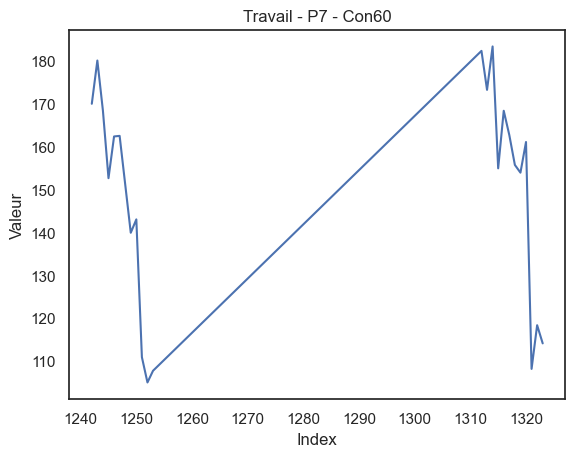

In [10]:
filtered_data = df_result[(df_result['participant'] == '007') & (df_result['contraction'] == 'CON60')]
travail_values = filtered_data['Travail']

plt.plot(travail_values)
plt.xlabel('Index')
plt.ylabel('Valeur')
plt.title('Travail - P7 - Con60')
plt.show()

## Importation du fichier contenant les poids de chaque participant en vue d'une normalisation des données

In [11]:
poids_file_path = "C:/Users/l.boisson/Documents/1- Projets traitement/ActivGun/240327_ActivGun_Donnees_anthropometriques.xlsx"
poids_file = pd.DataFrame()
sheet_name = f'Composition_corporelle'
poids_file = pd.read_excel(poids_file_path, sheet_name=sheet_name, header=[0], nrows=2).iloc[:, 1:-2]
poids_file = poids_file.drop(poids_file.index[0]) 
poids_file.columns = poids_file.columns.str.replace('P', '')
poids_file = poids_file.melt(var_name='participant', value_name='poids')
poids_file

,participant,poids
0,001,61.0
1,002,68.2
2,003,82.9
3,004,61.9
4,005,90.5
5,006,107.6
6,007,74.3
7,008,70.0


## Normalisation du couple, du travail et de la position de couple max par le poids

In [12]:
df_result = pd.merge(df_result, poids_file, on="participant", how="left")
df_result["Couple_normalise"] = df_result["Couple"].div(df_result["poids"])
df_result["Travail_normalise"] = df_result["Travail"].div(df_result["poids"])
df_result

,participant,condition,contraction,essai,mesure,Repetition,mouvement,Couple,Position_couple,Travail,poids,Couple_normalise,Travail_normalise
0,001,CH,CON60,1,01,1,Extension,171.792894,76.302059,142.354175,61.0,2.816277,2.333675
1,001,CH,CON60,1,01,2,Extension,159.033441,75.717773,132.696258,61.0,2.607106,2.175348
2,001,CH,CON60,1,01,3,Extension,168.530394,62.836003,135.360362,61.0,2.762793,2.219022
3,001,CH,CON60,1,02,1,Extension,158.456253,72.439359,124.549599,61.0,2.597643,2.041797
4,001,CH,CON60,1,02,2,Extension,151.376175,74.077803,121.009031,61.0,2.481577,1.983755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,008,H,ISO,1,21,1,Extension,344.034088,90.105263,0.176775,70.0,4.914773,0.002525
1582,008,H,ISO,2,01,1,Extension,336.885559,90.105263,0.131903,70.0,4.812651,0.001884
1583,008,H,ISO,2,02,1,Extension,313.969910,90.106789,1.581500,70.0,4.485284,0.022593
1584,008,H,ISO,2,11,1,Extension,299.639893,90.108314,0.442379,70.0,4.280570,0.006320


# Livrables CON60 par participant

### Calcul et mise en forme des variables 

In [13]:
df_result_con60 = df_result[df_result.contraction == 'CON60']

con60_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_mean = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_mean_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_max = process_data_participant(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data_participant(con60_couple_max_normalise, 'Couple_max_normalise')
con60_couple_mean = process_data_participant(con60_couple_mean, 'Moy_couple_max')
con60_couple_mean_normalise = process_data_participant(con60_couple_mean_normalise, 'Moy_couple_max_normalise')
con60_pos_couple_max = process_data_participant(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data_participant(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data_participant(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data_participant(con60_travail_max, 'Travail_max')

### Export des variables

In [14]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique_participant.xlsx") as writer:

    con60_couple_max.to_excel(writer, sheet_name='Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    con60_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    con60_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables CON60 avec participants moyennés

### Calcul et mise en forme des variables 

In [15]:
con60_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_max_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_couple_mean = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_couple_mean_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_pos_couple_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
con60_travail_moyen = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_moyen_normalise = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
con60_travail_max = df_result_con60.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

con60_couple_max = process_data(con60_couple_max, 'Couple_max')
con60_couple_max_normalise = process_data(con60_couple_max_normalise, 'Couple_max_normalise')
con60_couple_mean = process_data(con60_couple_mean, 'Moy_couple_max')
con60_couple_mean_normalise = process_data(con60_couple_mean_normalise, 'Moy_couple_max_normalise')
con60_pos_couple_max = process_data(con60_pos_couple_max, 'Position_couple_max')
con60_travail_moyen = process_data(con60_travail_moyen, 'Travail_moyen')
con60_travail_moyen_normalise = process_data(con60_travail_moyen_normalise, 'Travail_moyen_normalise')
con60_travail_max = process_data(con60_travail_max, 'Travail_max')
con60_couple_mean

Moy_couple_max                                 SD             \
condition             CH        CTRL           H         CH       CTRL   
mesure                                                                   
01            213.215420  200.028313  219.879178  58.204078  47.237064   
02            197.702147  184.482241  192.657569  51.002479  42.735662   
11            172.824521  157.082622  186.225154  57.491802  44.961117   
21            199.091051  158.303578  203.749997  57.288668  46.717023   

                            CV                      
condition          H        CH      CTRL         H  
mesure                                              
01         54.675030  0.266404  0.231180  0.243424  
02         48.351161  0.251759  0.226774  0.245685  
11         50.064889  0.324643  0.278979  0.263180  
21         40.310776  0.279644  0.287998  0.193679

### Export des variables

In [16]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_concentrique.xlsx") as writer:
    con60_couple_max.to_excel(writer, sheet_name='Couple_max')
    con60_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    con60_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    con60_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    con60_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    con60_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    con60_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    con60_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables ISO par participant

### Calcul et mise en forme des variables 

In [17]:
df_result_iso = df_result[df_result.contraction == 'ISO']
iso_couple_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_mean = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_mean_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_max = process_data_participant(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data_participant(iso_couple_max_normalise, 'Couple_max_normalise')
iso_couple_mean = process_data_participant(iso_couple_mean, 'Moy_couple_max')
iso_couple_mean_normalise = process_data_participant(iso_couple_mean_normalise, 'Moy_couple_max_normalise')
iso_travail_moyen = process_data_participant(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data_participant(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data_participant(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

Couple_max_normalise                                          \
condition                     CH                                           
participant                  001       002       003       004       005   
mesure                                                                     
01                      2.849343  3.453622  2.744983  2.879541  4.228122   
02                      2.670833  3.390184  2.977578  2.699594  4.368715   
11                      2.313278  3.129213  2.918088  2.052395  4.108013   
21                      2.515261  3.294351  2.696241  2.168929  4.168769   

                                                               ...        CV  \
condition                            CTRL                      ...      CTRL   
participant       006       008       001       002       003  ...       007   
mesure                                                         ...             
01           3.215123  4.308726  2.965345  3.341919  2.812849  ...  0.089305   
02           3.027624  4.456903  2.610138  3.393759  2.646131  ...  0.021293   
11           2.730522  4.879381  2.310645  2.890746  2.497160  ...  0.022184   
21           2.694070  4.948321  2.301059  3.061932  2.299620  ...  0.003426   

                                                                         \
condition                     H                                           
participant       008       001       002       003       004       005   
mesure                                                                    
01           0.024567  0.034683  0.000458  0.033215  0.006502  0.012143   
02           0.020953  0.020315  0.013765  0.016622  0.005693  0.019408   
11           0.003767  0.010697  0.016371  0.021166  0.082815  0.001547   
21           0.014725  0.031475  0.010825  0.035956  0.042053  0.010345   

                                           
condition                                  
participant       006       007       008  
mesure                                     
01           0.015431  0.005095  0.000021  
02           0.007189  0.000600  0.022426  
11           0.027448  0.000553  0.008100  
21           0.008412  0.004760  0.002549  

[4 rows x 69 columns]

In [18]:
iso_couple_max

Couple_max                                                  \
condition            CH                                                   
participant         001         002         003         004         005   
mesure                                                                    
01           173.809906  235.536987  227.559128  178.243576  382.645081   
02           162.920792  231.210571  246.841187  167.104874  395.368683   
11           141.109985  213.412354  241.909454  127.043274  371.775146   
21           153.430939  224.674713  223.518356  134.256714  377.273560   

                                                                         ...  \
condition                                  CTRL                          ...   
participant         006         008         001         002         003  ...   
mesure                                                                   ...   
01           345.947266  301.610840  180.886017  227.918854  233.185211  ...   
02           325.772369  311.983185  159.218399  231.454346  219.364288  ...   
11           293.804169  341.556671  140.949356  197.148865  207.014526  ...   
21           289.881897  346.382477  140.364594  208.823761  190.638519  ...   

                   CV                                                    \
condition        CTRL                   H                                 
participant       007       008       001       002       003       004   
mesure                                                                    
01           0.089305  0.024567  0.034683  0.000458  0.033215  0.006502   
02           0.021293  0.020953  0.020315  0.013765  0.016622  0.005693   
11           0.022184  0.003767  0.010697  0.016371  0.021166  0.082815   
21           0.003426  0.014725  0.031475  0.010825  0.035956  0.042053   

                                                     
condition                                            
participant       005       006       007       008  
mesure                                               
01           0.012143  0.015431  0.005095  0.000021  
02           0.019408  0.007189  0.000600  0.022426  
11           0.001547  0.027448  0.000553  0.008100  
21           0.010345  0.008412  0.004760  0.002549  

[4 rows x 69 columns]

### Export des variables

In [19]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique_participant.xlsx") as writer:
    iso_couple_max.to_excel(writer, sheet_name='Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    iso_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    iso_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables ISO avec participants moyennés

### Calcul et mise en forme des variables 

In [20]:
iso_couple_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_max_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_couple_mean = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_couple_mean_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Couple_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
iso_travail_moyen = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_moyen_normalise = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
iso_travail_max = df_result_iso.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()

iso_couple_max = process_data(iso_couple_max, 'Couple_max')
iso_couple_max_normalise = process_data(iso_couple_max_normalise, 'Couple_max_normalise')
iso_couple_mean = process_data(iso_couple_mean, 'Moy_couple_max')
iso_couple_mean_normalise = process_data(iso_couple_mean_normalise, 'Moy_couple_max_normalise')
iso_travail_moyen = process_data(iso_travail_moyen, 'Travail_moyen')
iso_travail_moyen_normalise = process_data(iso_travail_moyen_normalise, 'Travail_moyen_normalise')
iso_travail_max = process_data(iso_travail_max, 'Travail_max')
iso_couple_max_normalise

Couple_max_normalise                            SD            \
condition                   CH      CTRL         H        CH      CTRL   
mesure                                                                   
01                    4.308726  4.082043  4.812651  0.611181  0.450658   
02                    4.456903  3.801793  4.695909  0.728308  0.394953   
11                    4.879381  3.718679  4.280570  0.941861  0.506908   
21                    4.948321  4.014558  4.939958  0.950530  0.672285   

                           CV                      
condition         H        CH      CTRL         H  
mesure                                             
01         0.655545  0.136688  0.106894  0.131888  
02         0.600977  0.157467  0.100587  0.123915  
11         0.601591  0.186007  0.131356  0.136077  
21         0.847845  0.185104  0.161370  0.166180

### Export des variables

In [21]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_isometrique.xlsx") as writer:

    iso_couple_max.to_excel(writer, sheet_name='Couple_max')
    iso_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    iso_couple_mean.to_excel(writer, sheet_name='Moy_couple_max')
    iso_couple_mean_normalise.to_excel(writer, sheet_name='Moy_couple_max_normalise')
    iso_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    iso_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')
    iso_travail_max.to_excel(writer, sheet_name='Travail_max')

# Livrables EXC par participant

### Calcul et mise en forme des variables 

In [22]:
df_result_exc = df_result[df_result.contraction == 'EXC']
df_result_exc['essai'] = df_result_exc['essai'].astype(int)
df_result_exc = df_result_exc.sort_values(by='essai')

exc_couple_max = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_couple_max_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_pos_couple_max = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_travail_moyen_participant_essai = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_essai_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_participant_normalise = df_result_exc.groupby(['participant', 'condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_couple_max = process_data_essai(exc_couple_max, 'Couple_max')
exc_couple_max_normalise = process_data_essai(exc_couple_max_normalise, 'Couple_max_normalise')
exc_pos_couple_max = process_data_essai(exc_pos_couple_max, 'Pos_couple_max')
exc_travail_moyen_participant_essai = process_data_essai(exc_travail_moyen_participant_essai, 'Travail_moyen_essai')
exc_travail_moyen_participant_essai_normalise = process_data_essai(exc_travail_moyen_participant_essai_normalise, 'Travail_moyen_normalise_essai')
exc_travail_moyen_participant = process_data_participant(exc_travail_moyen_participant, 'Travail_moyen')
exc_travail_moyen_participant_normalise = process_data_participant(exc_travail_moyen_participant_normalise, 'Travail_moyen_normalise')

C:\Users\l.boisson\AppData\Local\Temp\ipykernel_5144\960495664.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result_exc['essai'] = df_result_exc['essai'].astype(int)


In [23]:
exc_travail_moyen_participant_normalise

Travail_moyen_normalise                                         \
condition                        CH                                          
participant                     001       002       003       004      005   
mesure                                                                       
0                          2.269641  2.147368  2.628232  3.097642  2.86156   

                                                               ...        CV  \
condition                            CTRL                      ...      CTRL   
participant       006       008       001       002       003  ...       007   
mesure                                                         ...             
0            2.679671  2.687669  2.668331  2.495157  2.697929  ...  0.190308   

                                                                       \
condition                     H                                         
participant       008       001       002     003       004       005   
mesure                                                                  
0            0.155317  0.088377  0.066267  0.0903  0.125687  0.148343   

                                           
condition                                  
participant       006       007       008  
mesure                                     
0            0.083888  0.108964  0.135499  

[1 rows x 69 columns]

### Export des variables

In [24]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique_participant.xlsx") as writer:
    exc_couple_max.to_excel(writer, sheet_name='Couple_max')
    exc_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    exc_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    exc_travail_moyen_participant_essai.to_excel(writer, sheet_name='Travail_moyen_essai')
    exc_travail_moyen_participant_essai_normalise.to_excel(writer, sheet_name='Travail_moyen_norm_essai')
    exc_travail_moyen_participant.to_excel(writer, sheet_name='Travail_moyen')
    exc_travail_moyen_participant_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')

# Livrables EXC avec participants moyennés

### Calcul et mise en forme des variables 

In [25]:
exc_couple_max = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_couple_max_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Couple_normalise'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_pos_couple_max = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Position_couple'].agg(['max', 'std', lambda x: np.std(x) / np.max(x)]).reset_index()
exc_travail_moyen_essai = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_essai_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure', 'essai'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()
exc_travail_moyen_normalise = df_result_exc.groupby(['condition', 'contraction', 'mesure'])['Travail_normalise'].agg(['mean', 'std', lambda x: np.std(x) / np.mean(x)]).reset_index()

exc_couple_max = process_data_participant(exc_couple_max, 'Couple_max')
exc_couple_max_normalise = process_data_participant(exc_couple_max_normalise, 'Couple_max_normalise')
exc_pos_couple_max = process_data_participant(exc_pos_couple_max, 'Pos_couple_max')
exc_travail_moyen_essai = process_data_participant(exc_travail_moyen_essai, 'Travail_moyen_essai')
exc_travail_moyen_essai_normalise = process_data_participant(exc_travail_moyen_essai_normalise, 'Travail_moyen_normalise_essai')
exc_travail_moyen = process_data(exc_travail_moyen, 'Travail_moyen')
exc_travail_moyen_normalise = process_data(exc_travail_moyen_normalise, 'Travail_moyen_normalise')
exc_travail_moyen

Travail_moyen                                 SD             \
condition            CH        CTRL           H         CH       CTRL   
mesure                                                                  
0            204.462208  208.786722  194.339649  57.800391  51.427711   

                            CV                      
condition          H        CH      CTRL         H  
mesure                                              
0          46.967546  0.282285  0.246009  0.241372

### Export des variables

In [26]:
with pd.ExcelWriter(path_export + f"{today}_ActivGun_excentrique.xlsx") as writer:
    exc_couple_max.to_excel(writer, sheet_name='Couple_max')
    exc_couple_max_normalise.to_excel(writer, sheet_name='Couple_max_normalise')
    exc_pos_couple_max.to_excel(writer, sheet_name='Pos_couple_max')
    exc_travail_moyen_essai.to_excel(writer, sheet_name='Travail_moyen_essai')
    exc_travail_moyen_essai_normalise.to_excel(writer, sheet_name='Travail_moyen_norm_essai')
    exc_travail_moyen.to_excel(writer, sheet_name='Travail_moyen')
    exc_travail_moyen_normalise.to_excel(writer, sheet_name='Travail_moyen_normalise')